In [30]:
import numpy as np
import gsd
import gsd.hoomd
import os
import glob
import freud
workdir1 = "/scratch/projects/hockygroup/sp6310/ionic_crystal/ionic_crystal/ExperimentalData/New_simulation2/corrected_pot2/charged_wall/\
SP-45/prod2_v2/bulk_LS4.5_FP0.5_RN105_BL10_DL5.15" #CsCl
workdir2 = "/scratch/projects/hockygroup/sp6310/ionic_crystal/ionic_crystal/ExperimentalData/New_simulation2/corrected_pot2/charged_wall/\
fromGlenRun/LS4.5DL5.15" #Zanganite
gsdfile1 = glob.glob(os.path.join(workdir1, "*gsd"))[0]
gsdfile2 = glob.glob(os.path.join(workdir2, "*gsd"))[0]
print(gsdfile1)
print(gsdfile2)
traj1 = gsd.hoomd.open(gsdfile1, mode = "rb")
traj2 = gsd.hoomd.open(gsdfile2, mode = "rb")

/scratch/projects/hockygroup/sp6310/ionic_crystal/ionic_crystal/ExperimentalData/New_simulation2/corrected_pot2/charged_wall/SP-45/prod2_v2/bulk_LS4.5_FP0.5_RN105_BL10_DL5.15/trajectory_LS4.5_FP0.5_RN105_BL10_DL5.15_N4000000000.gsd
/scratch/projects/hockygroup/sp6310/ionic_crystal/ionic_crystal/ExperimentalData/New_simulation2/corrected_pot2/charged_wall/fromGlenRun/LS4.5DL5.15/trajectory_LS4.5_FP0.5_RN105_BL10_DL5.15_N2000000000.gsd


In [31]:
def get_largestcluster(positions,typeid,box):
    npart = len(positions)
    cl = freud.cluster.Cluster()
    cl.compute((box,positions), neighbors = {'r_max':290})
    cl_indices = cl.cluster_idx
    ind_lrg = np.where(cl_indices==0)[0]
    pos_lrg = positions[ind_lrg]
    type_lrg = typeid[ind_lrg]
    
    return pos_lrg, type_lrg

    

In [32]:
def addsheet(pos_lrg,box):
    boxZmin = -box[2]/2
    xmin,ymin = np.min(pos_lrg[:,[0,1]], axis=0)
    xmax,ymax = np.max(pos_lrg[:,[0,1]], axis=0)
    dS = 60.
    rS = dS/2
    posZ = boxZmin + 1.5*rS
    min_x = xmin - 300.
    max_x = xmax + 300.
    min_y = ymin - 300.
    max_y = ymax + 300. 
    dL = np.sqrt(dS**2 - rS**2)
    posX1 = np.arange(min_x,max_x,dS)
    posX2 = np.arange(min_x+rS, max_x-rS, dS)
    posY1 = np.arange(min_y,max_y,2.*dL)
    posY2 = np.arange(min_y+dL, max_y-dL,2.*dL)
    pos_sheet = []
    for i in range(len(posX1)):
        for j in range(len(posY1)):
            pos_sheet.append([posX1[i],posY1[j],posZ])
    for i in range(len(posX2)):
        for j in range(len(posY2)):
            pos_sheet.append([posX2[i],posY2[j],posZ])
    return pos_sheet


In [72]:
def get_energy(r1,r2,sp1,sp2,r,rmax,dl):
    #dl=5.5
    mV_to_kBT = 25.7
    joule_to_kBT = 4.11e-21
    brush_length = 10.
    brush_density = 0.09
    ionic_radius  = 2./(1./r1 + 1./r2)
    repulsion_radius = (r1 + r2)/2.
    brush2 = brush_length*2
    steric_prefactor = np.pi*16*repulsion_radius*(brush_length**2)*(brush_density**(3./2))/35.
    permitivity = 8.85e-12 #Farad/M
    dielectric_constant = 80.
    ionic_radius_in_m = 1e-9*ionic_radius
    r1_in_m = 1e-9*r1
    r2_in_m = 1e-9*r2
    surface_potentialN_in_V = sp1/1000
    surface_potentialP_in_V = sp2/1000
    electrostatic_prefactors = 2*np.pi*dielectric_constant*permitivity*ionic_radius_in_m/joule_to_kBT*surface_potentialN_in_V*surface_potentialP_in_V
    h = r - (r1 + r2)
    hcut = rmax - (r1 + r2)
    a = electrostatic_prefactors/dl*np.exp(-hcut/dl)
    b = -electrostatic_prefactors*np.exp(-hcut/dl) - hcut*a

    ve = electrostatic_prefactors *np.exp(-h/dl) +a*h + b
    vr = steric_prefactor*(28*((brush2/h)**.25-1) + 20./11*(1-(h/brush2)**2.75)+ 12*(h/brush2-1))
    return ve, vr*(h<brush2)

    
    

In [210]:
import matplotlib.pyplot as plt
rP = 85.
rN = 105.
rS = 30.
sP = 50.
sN = -50
sS = -50
dl = 5.7
rall = []
rmax = rP +rS + 10*dl
snap = traj2[-1]
positions = snap.particles.position
typeid = snap.particles.typeid
box = snap.configuration.box
pos_lrg, type_lrg = get_largestcluster(positions, typeid, box)
print(len(pos_lrg))
pos_sheet = addsheet(pos_lrg,box)
#pos_layer1 = pos_lrg[pos_lrg[:,2] < -4800] #-3625] #-4800]
#pos_layer2 = pos_lrg[(pos_lrg[:,2] > -4800) & (pos_lrg[:,2] < -4650)] #-3530)]#-4650)]
pos_layer1 = pos_lrg[pos_lrg[:,2] < -3625] #-3625] #-4800]
pos_layer2 = pos_lrg[(pos_lrg[:,2] > -3625) & (pos_lrg[:,2] < -3530)] #-3530)]#-4650)]
print(len(pos_layer1))
print(len(pos_layer2))

for i in range(len(pos_layer1)):
    pos = pos_layer1[i]
    posbrd = np.broadcast_to(pos,(len(pos_sheet),3))
    dr = posbrd - pos_sheet
    r = np.sqrt(np.sum(dr**2, axis=1))
    rnbr = r[r<rmax]
    rall.extend(rnbr)
rall = np.array(rall)
ve, vr = get_energy(rP,rS,sP,sS,rall,rmax,dl)
print(ve[0:10])
print(vr[0:10])
energy = (np.sum(ve) + np.sum(vr))/len(pos_layer1)
print(energy)
#print(np.sum(ve)/len(pos_layer1))
#print(np.sum(vr)/len(pos_layer1))
#hist, bin_edges = np.histogram(rall)
#bins = (bin_edges[:-1] + bin_edges[1:])/2
#plt.plot(bins, hist)

1051
157
160
[-1.40043891e-01 -5.77569327e+00 -2.58402269e-02 -2.29367417e+00
 -7.38298965e-03 -4.72593639e-03 -1.22820096e-01 -6.43049554e-01
 -4.98999731e-01 -2.61278790e+00]
[-0.          2.78164957 -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.        ]
-9.95604655254272


In [211]:
rall = []
rmax = rP + rN + (10*dl)
for i in range(len(pos_layer1)):
    pos = pos_layer1[i]
    posbrd = np.broadcast_to(pos,(len(pos_layer2),3))
    dr = posbrd - pos_layer2
    r = np.sqrt(np.sum(dr**2, axis=1))
    rnbr = r[r<rmax]
    rall.extend(rnbr)
rall = np.array(rall)
ve, vr = get_energy(rP,rN,sP,sN,rall,rmax,dl)
print(ve[0:10])
print(vr[0:10])
energy = (np.sum(ve) + np.sum(vr))/len(pos_layer1)
print(energy)

[ -5.4919767 -10.106902   -7.6490955 -10.731811   -9.102686   -9.215854
 -10.43144    -9.703306  -10.031791   -9.100402 ]
[-0.0000000e+00  9.8796868e-01 -7.9593447e-05  1.7422291e+00
  2.6084691e-01  3.1475091e-01  1.3492022e+00  6.2787700e-01
  9.1329360e-01  2.5924408e-01]
-29.5134666102707


In [212]:
rall = []
rmax = rP + rP + (10*dl)
for i in range(len(pos_layer1)):
    pos = pos_layer1[i]
    posbrd = np.broadcast_to(pos,(len(pos_layer1)-1,3))
    pos_layer1_ = np.delete(pos_layer1, i, axis=0)
    dr = posbrd - pos_layer1_
    r = np.sqrt(np.sum(dr**2, axis=1))
    rnbr = r[r<rmax]
    rall.extend(rnbr)
rall = np.array(rall)
ve, vr = get_energy(rP,rP,sP,sP,rall,rmax,dl)
print(ve[0:10])
print(vr[0:10])
energy = (np.sum(ve) + np.sum(vr))/len(pos_layer1)
print(energy)

[0.06349553 0.08072926 0.02131154 0.00473233 0.03251414 0.02022806
 0.11097281 0.0152853  0.00162863 0.22516261]
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
0.04878986565170774


In [213]:
rall = []
rmax = rP + rP + (10*dl)
vrall = 0
veall = 0
for i in range(len(pos_layer1)-1):
    for j in range(i+1,len(pos_layer1)):
        pos = pos_layer1[i]
        posj = pos_layer1[j]
        #posbrd = np.broadcast_to(pos,(len(pos_layer1)-1,3))
        #pos_layer1_ = np.delete(pos_layer1, i, axis=0)
        dr = pos - posj
        r = np.sqrt(np.sum(dr**2))
        if r < rmax:
            
        #rall.extend(r)
        #rall = np.array(rall)
            ve, vr = get_energy(rP,rP,sP,sP,r,rmax,dl)
            vrall = vrall + vr
            veall = veall + ve
#energy = (np.sum(ve) + np.sum(vr))/len(pos_layer1)
print(veall, vrall)
print((veall + vrall)/len(pos_layer1))

#print(energy)

3.8300058666460965 0.0
0.024394941825771316


In [49]:
rall = []
rmax = rN + rS + 10*dl
for i in range(len(pos_layer2)):
    pos = pos_layer2[i]
    posbrd = np.broadcast_to(pos,(len(pos_sheet),3))
    dr = posbrd - pos_sheet
    r = np.sqrt(np.sum(dr**2, axis=1))
    rnbr = r[r<rmax]
    rall.extend(rnbr)
rall = np.array(rall)
ve, vr = get_energy(rN,rS,sN,sS,rall)
print(ve[0:10])
print(vr[0:10])
energy = (np.sum(ve) + np.sum(vr))/len(pos_layer1)
print(energy)

[]
[]
0.0


/home/sp6310/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sp6310/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


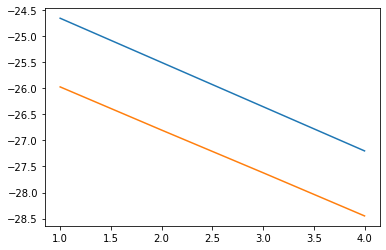

In [50]:
x = np.array([1,2,3,4])
y1 = np.array([-24.65,-25.50,-26.35,-27.20])
y2 = np.array([-25.97,-26.80,-27.62,-28.45])
import matplotlib.pyplot as plt
plt.plot(x,y1)
plt.plot(x,y2)

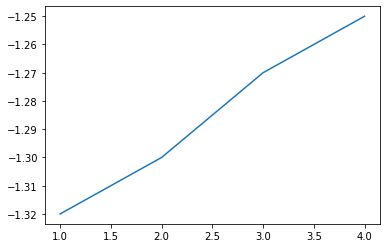

In [52]:
dy = y2-y1
plt.plot(x,dy)